In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import PIL
import os
import random
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Activation, Flatten, MaxPooling2D, Conv2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import utils
import keras_tuner as kt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-12-09 07:43:04.373494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 07:43:05.501969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2022-12-09 07:43:05.502259: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2022-12-09 07:43:05.502

Num GPUs Available:  1


In [2]:
NAME = "RUN-1"

In [3]:
## Load training data

# https://www.youtube.com/watch?v=OOIrxx_ts4I

x = []

for f in tqdm(os.listdir("data")):
    img = PIL.Image.open(f"data/{f}")
    img = np.array(img) / 255.0
    img = cv2.resize(img, (256,256))
    x.append(img)

100%|██████████| 1000/1000 [00:01<00:00, 756.81it/s]


In [4]:
## Generate Masks

y = []

coco = COCO("annotations.json")
category_ids = coco.getCatIds()

for i in tqdm(coco.imgs.keys()):
    img = coco.imgs[i]
    annotation_ids = coco.getAnnIds(imgIds=img['id'], catIds=category_ids, iscrowd=None)
    annotations = coco.loadAnns(annotation_ids)

    try:
        mask = coco.annToMask(annotations[0])

        for a in annotations:
            mask += coco.annToMask(a)

        mask = cv2.resize(mask, (256,256))

        y.append(mask)
    except:
        y.append(np.zeros((256,256)))



loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


100%|██████████| 1000/1000 [00:00<00:00, 2515.90it/s]


In [5]:
## Build Model

def make_encoder(inputs, n_filters=32, dropout_rate=0.2, pooling=True):
    x = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    x = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(x)
  
    skip = BatchNormalization()(x, training=False)
    skip = Dropout(dropout_rate)(skip)

    if pooling:
        x = MaxPooling2D(pool_size = (2,2))(skip)
    else:
        x = skip

    return x, skip

def make_decoder(prev_layer_input, skip_layer_input, n_filters=32):
    up = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same')(prev_layer_input)
    merge = concatenate([up, skip_layer_input], axis=-1)
    x = Conv2D(n_filters, 3,activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    x = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(x)
    return x

def make_unet(input_shape, n_filters=32, n_classes=10, blocks=4, dropout_rate=0.2):

    inputs = Input(input_shape)

    encoder_blocks = []

    x = make_encoder(inputs, n_filters, dropout_rate=dropout_rate, pooling=True)
    prev_input = x[0]
    encoder_blocks.append(x)

    for i in range(blocks):
        x = make_encoder(prev_input, n_filters * (2**(i + 1)), dropout_rate=dropout_rate, pooling=(i!=blocks-1))
        encoder_blocks.append(x)
        prev_input = x[0]

    for i in range(blocks - 1, -1, -1):
        x = make_decoder(prev_input, encoder_blocks[i][1], n_filters * (2**i))
        prev_input = x

    x = Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = Conv2D(n_classes, 1, padding="same")(x)

    model = Model(inputs=inputs, outputs=x)

    model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    return model

In [6]:
def build_model_hp(hp):
    blocks = hp.Int("blocks", min_value=4, max_value=6, step=1)
    n_filters = hp.Int("n_filters", min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.1)
    return make_unet((256,256,3), n_filters=n_filters, blocks=blocks, dropout_rate=dropout_rate)

In [7]:
shuffled = list(zip(x, y))
random.shuffle(shuffled)
x = [i[0] for i in shuffled]
y = [i[1] for i in shuffled]

train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.1)

train_x = np.array(train_x)
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

In [8]:
# Train

MAX_TRIALS = 200

tuner = kt.BayesianOptimization(
                    max_trials=MAX_TRIALS,
                    hypermodel=build_model_hp,
                    objective="val_accuracy",
                    overwrite=False,
                    directory=f"tuners/{NAME}",
                    project_name=f"{NAME}",)

tuner.search_space_summary(extended=True)

INFO:tensorflow:Reloading Oracle from existing project tuners/RUN-1/RUN-1/oracle.json


2022-12-09 07:43:10.573868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 07:43:11.239605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22285 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:c1:00.0, compute capability: 8.6


INFO:tensorflow:Reloading Tuner from tuners/RUN-1/RUN-1/tuner0.json
Search space summary
Default search space size: 3
blocks (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 6, 'step': 1, 'sampling': None}
n_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}


In [9]:
EPOCHS = 10
BATCH_SIZE = 4


with tf.device("/device:GPU:0"):
    tuner.search(train_x, train_y, 
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                validation_data=(val_x, val_y))

Trial 32 Complete [00h 01m 34s]
val_accuracy: 0.8479633927345276

Best val_accuracy So Far: 0.8750419616699219
Total elapsed time: 01h 18m 23s



Search: Running Trial #33

Value             |Best Value So Far |Hyperparameter
4                 |4                 |blocks
32                |32                |n_filters
0.2               |0.2               |dropout_rate

Epoch 1/10


2022-12-09 07:41:51.542980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


225/225 [==============================] - 18s 39ms/step - loss: 0.7423 - accuracy: 0.7442 - val_loss: 0.4965 - val_accuracy: 0.7757
Epoch 2/10
225/225 [==============================] - 8s 37ms/step - loss: 0.4780 - accuracy: 0.7743 - val_loss: 0.3919 - val_accuracy: 0.8196
Epoch 3/10
225/225 [==============================] - 8s 36ms/step - loss: 0.4519 - accuracy: 0.7868 - val_loss: 0.3882 - val_accuracy: 0.8179
Epoch 4/10
225/225 [==============================] - 8s 35ms/step - loss: 0.4382 - accuracy: 0.7971 - val_loss: 0.3939 - val_accuracy: 0.8196
Epoch 5/10
225/225 [==============================] - 8s 37ms/step - loss: 0.4413 - accuracy: 0.7926 - val_loss: 0.3776 - val_accuracy: 0.8225
Epoch 6/10
225/225 [==============================] - 8s 37ms/step - loss: 0.4102 - accuracy: 0.8211 - val_loss: 0.3654 - val_accuracy: 0.8467
Epoch 7/10
211/225 [===========================>..] - ETA: 0s - loss: 0.3957 - accuracy: 0.8321

In [19]:
tuner.get_best_hyperparameters(1)[0].values

{'blocks': 4, 'n_filters': 32, 'dropout_rate': 0.2}

In [9]:
model = tuner.get_best_models(1)[0]

1/1 [==============================] - 0s 31ms/step
Image:


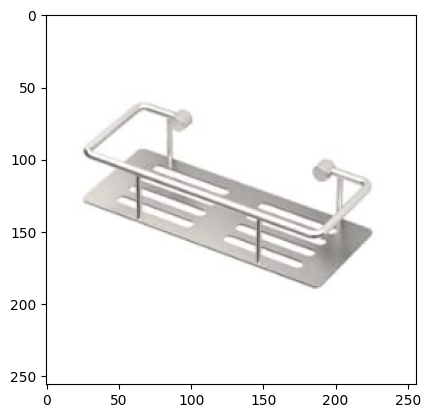

Actual:


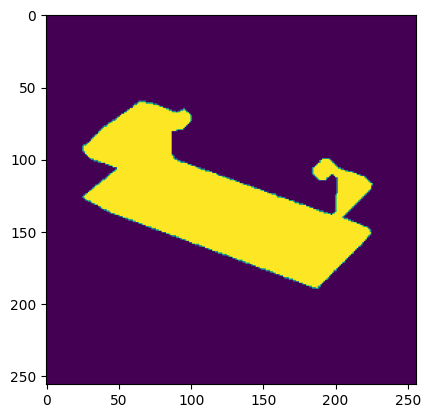

Pred:


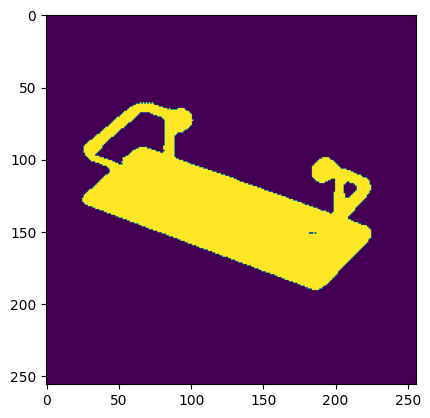

In [17]:
idx = 436

pred = model.predict(np.array([train_x[idx]]))

print("Image:")
plt.imshow(train_x[idx])
plt.show()
print("Actual:")
plt.imshow(train_y[idx])
plt.show()
print("Pred:")
pred = tf.argmax(pred[0], axis=-1)
plt.imshow(pred)
plt.show()